In [1]:
# Importo las librerías Necesarias 
import numpy as np # Importo algebra Lineal
import matplotlib.pyplot as plt # Importo librería de gráficos
import math
import gmsh #Importo gmsh
import mef
from scipy import linalg
plt.rc('figure', figsize=(10,5))   # Para gráficos
plt.rc('font',size=15)             # Para gráficos

# Problema 1

Calcule las frecuencias naturales de oscilación transversal de una barra de acero (densidad $ 7850 kg/m^3 $ y módulo de elasticidad $ E = 210 GPa $), de $ 1 m $ de longitud, $ 10 cm^2 $ de área, momento de inercia de $ 10 cm^4 $.Realice el cálculo para un número variable de elementos y estudie la convergencia de sus resultados. Haga el cálculo para matrices de masa concentrada y consistente.

Grafique los desplazamientos en función de la posición para los primeros modos normales.

<center><img src="Ej 1.png"></center>


## Desarrollo

In [27]:
# Datos

rho = 7850 #kg/m^3 (densidad)
E = 210E9 #Pa (módulo de ellasticidad)
L = 1 #m (longitud)
A = 10E-4 #m^2 (sección)
I = 10E-8 #m^4 (momento de inercia)

glxn = 2 #grados de libertad

In [28]:
# Número de elementos
n_element = [10, 100]

### Matriz consistente

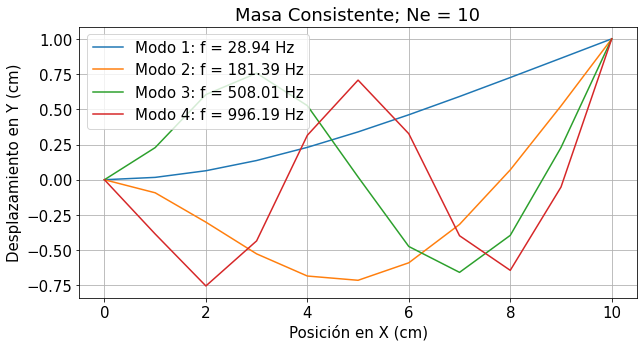

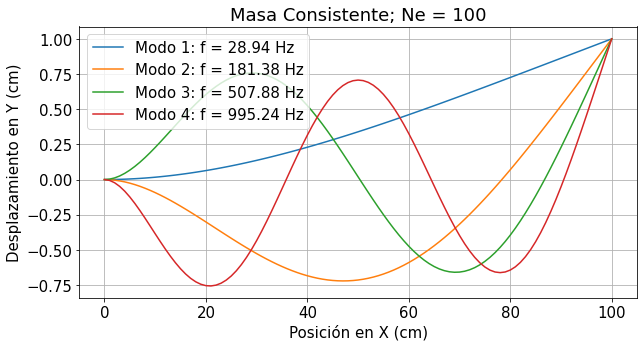

In [33]:
for i in range(2):
    # Matriz de nodos
    MN = np.linspace(0,L,n_element[i]+1).reshape(-1,1)
    MN = np.hstack([MN,np.zeros([n_element[i]+1,2])])
    n_nodos = MN.shape[0]

    # Matriz de conectividad
    MC = np.array([[i, i+1] for i in range(n_element[i])])
    n_nxe = MC.shape[1]
    
    #longitud de los elementos
    Le = L/n_element[i]
    
    # Condiciones de vinculo en desplazamiento
    S = [0, 1]
    R = np.array([i for i in range(n_nodos*glxn) if i not in S]) #complemento de S
    
    # Matriz de rigidez
    MR = (E*I/Le**3)*np.array([[  12,      6*Le,    -12,     6*Le],
                               [6*Le,   4*Le**2,  -6*Le,  2*Le**2],
                               [ -12,     -6*Le,     12,    -6*Le],
                               [6*Le,   2*Le**2,  -6*Le,  4*Le**2]])
    
    # Matriz de rigidez global
    Kg = mef.MG(MN, MC, glxn, MR)
    
    # Matriz consistente
    MCons = (rho*A*Le/420)*np.array([[   156,    22*Le,     54,   -13*Le],
                                     [ 22*Le,  4*Le**2,  13*Le, -3*Le**2],
                                     [    54,    13*Le,    156,   -22*Le],
                                     [-13*Le, -3*Le**2, -22*Le,  4*Le**2]])
    
    # Matriz consistente global
    MG_Cons = mef.MG(MN, MC, glxn, MCons)
    
    # Resuelvo problema de autovalores y autovectores
    omega_2_cons, Vr_cons = linalg.eigh(Kg[np.ix_(R,R)],MG_Cons[np.ix_(R,R)]) # Modos normales y desplazamientos
    frec_cons = np.sqrt(omega_2_cons)/(2*np.pi) # Frecuencia de los modos normales
    
    # Considero los nodos con condición de vinculo agregando filas nulas
    V_cons = np.vstack([np.zeros([len(S), len(omega_2_cons)]),Vr_cons])
    
    desp_cons = V_cons[::2, :]   # Nos quedamos con los desplazamientos
    desp_cons = desp_cons/desp_cons[-1, :]     # Normalizamos los desplazamientos
    
    # Grafico los primeros 4 modos normales.
    for e in range(4):   
        plt.plot(np.arange(n_element[i]+1), desp_cons[:, e], label='Modo '+str(e+1)+': f = '+str(round(frec_cons[e], 2))+' Hz')
    plt.legend()
    plt.grid()
    plt.title('Masa Consistente; Ne = '+str(round(n_element[i], 2)))
    plt.xlabel('Posición en X (cm)')
    plt.ylabel('Desplazamiento en Y (cm)')
    plt.show()

### Matriz concentrada

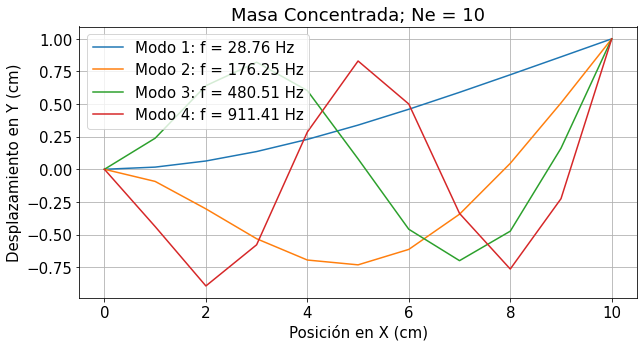

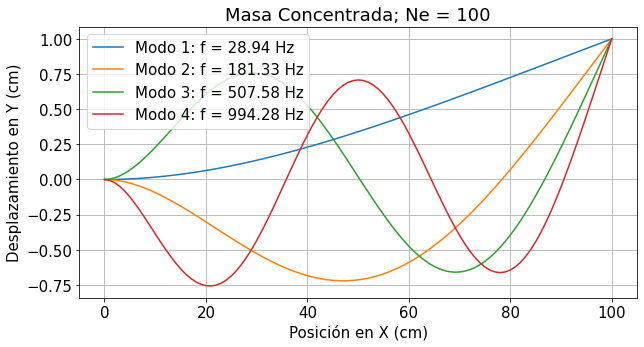

In [34]:
for i in range(2):
    # Matriz de nodos
    MN = np.linspace(0,L,n_element[i]+1).reshape(-1,1)
    MN = np.hstack([MN,np.zeros([n_element[i]+1,2])])
    n_nodos = MN.shape[0]

    # Matriz de conectividad
    MC = np.array([[i, i+1] for i in range(n_element[i])])
    n_nxe = MC.shape[1]
    
    #longitud de los elementos
    Le = L/n_element[i]
    
    # Condiciones de vinculo en desplazamiento
    S = [0, 1]
    R = np.array([i for i in range(n_nodos*glxn) if i not in S]) #complemento de S
    
    # Matriz de rigidez
    MR = (E*I/Le**3)*np.array([[  12,      6*Le,    -12,     6*Le],
                               [6*Le,   4*Le**2,  -6*Le,  2*Le**2],
                               [ -12,     -6*Le,     12,    -6*Le],
                               [6*Le,   2*Le**2,  -6*Le,  4*Le**2]])
    
    # Matriz de rigidez global
    Kg = mef.MG(MN, MC, glxn, MR)
    
    # Matriz concentrada
    MConc = (rho*A*Le/24)*np.array([[12,     0,  0,     0],
                                    [ 0, Le**2,  0,     0],
                                    [ 0,     0, 12,     0],
                                    [ 0,     0,  0, Le**2]])
    
    # Matriz concentrada global
    MG_Conc = mef.MG(MN, MC, glxn, MConc)
    
    # Resuelvo problema de autovalores y autovectores
    omega_2_conc, Vr_conc = linalg.eigh(Kg[np.ix_(R,R)],MG_Conc[np.ix_(R,R)]) # Modos normales y desplazamientos
    frec_conc = np.sqrt(omega_2_conc)/(2*np.pi) # Frecuencia de los modos normales
    
    # Considero los nodos con condición de vinculo agregando filas nulas
    V_conc = np.vstack([np.zeros([len(S), len(omega_2_conc)]),Vr_conc])
    
    desp_conc = V_conc[::2, :]   # Nos quedamos con los desplazamientos
    desp_conc = desp_conc/desp_conc[-1, :]     # Normalizamos los desplazamientos
    
    # Grafico los primeros 4 modos normales.
    for e in range(4):   
        plt.plot(np.arange(n_element[i]+1), desp_conc[:, e], label='Modo '+str(e+1)+': f = '+str(round(frec_conc[e], 2))+' Hz')
    plt.legend()
    plt.grid()
    plt.title('Masa Concentrada; Ne = '+str(round(n_element[i], 2)))
    plt.xlabel('Posición en X (cm)')
    plt.ylabel('Desplazamiento en Y (cm)')
    plt.show()